In [1]:
import sys
import os

parent = os.path.dirname(os.path.realpath('../'))
sys.path.append(parent)

import numpy as np
# import open3d as o3d
import matplotlib.pyplot as plt

from musik import *

from utils import geometry

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
test_phantom = phantom.Phantom(
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (128,128,64),
            baseline = (1540, 1000),
            seed = 5678,)

water = tissue.Tissue(name='water', c=1540, rho=1000, sigma=0, scale=0.0001, label=0)
t1 = tissue.Tissue(name='t1', c=1540, rho=1000, sigma=0, scale=0.0001, label=1)
t2 = tissue.Tissue(name='t2', c=1540, rho=1000, sigma=20, scale=0.0001, label=2)
t3 = tissue.Tissue(name='t3', c=1540, rho=1000, sigma=30, scale=0.0001, label=3)
t4 = tissue.Tissue(name='t4', c=1540, rho=1000, sigma=60, scale=0.0001, label=4)
t5 = tissue.Tissue(name='t5', c=1540, rho=1000, sigma=80, scale=0.0001, label=5)

pos = 0.012
test_phantom.add_tissue(water, mask=np.ones(test_phantom.matrix_dims))

test_phantom.add_tissue_sphere((-pos,-2*pos,0), 3, t1)
test_phantom.add_tissue_sphere((-pos,-pos,0), 3, t2)
test_phantom.add_tissue_sphere((-pos,0,0), 3, t3)
test_phantom.add_tissue_sphere((-pos,pos,0), 3, t4)
test_phantom.add_tissue_sphere((-pos,2*pos,0), 3, t5)
test_phantom.add_tissue_sphere((pos,-2*pos,0), 3, t5)
test_phantom.add_tissue_sphere((pos,-pos,0), 3, t4)
test_phantom.add_tissue_sphere((pos,0,0), 3, t3)
test_phantom.add_tissue_sphere((pos,pos,0), 3, t2)
test_phantom.add_tissue_sphere((pos,2*pos,0), 3, t1)
    
test_phantom.set_default_tissue('water')
test = test_phantom.get_complete()

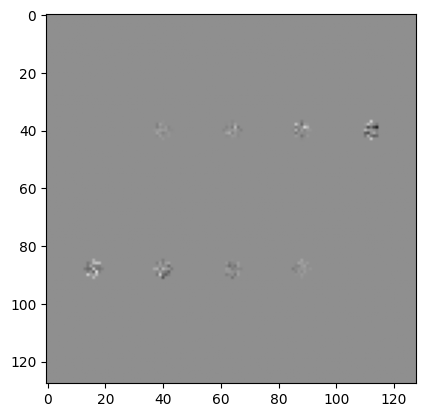

In [3]:
index = 32
plt.imshow(test_phantom.get_complete()[0, :, :, index], cmap='gray', vmin=1400, vmax=1650)

In [4]:
num_transducers = 1

transducers = [transducer.Focused(max_frequency = 1e6, # Increase the frequency for a higher quality image
                                  elements = 128, 
                                  width = 20e-3,
                                  height =  20e-3,
                                  sensor_sampling_scheme = 'not_centroid', 
                                  sweep = np.pi/2,
                                  ray_num = 64,
                                  imaging_ndims = 2,
                                  focus_azimuth = 64-3,
                                  focus_elevation = 96-3) for i in range(num_transducers)]


for t in transducers:
    t.make_sensor_coords(1540) # test_phantom.baseline[0]

test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)

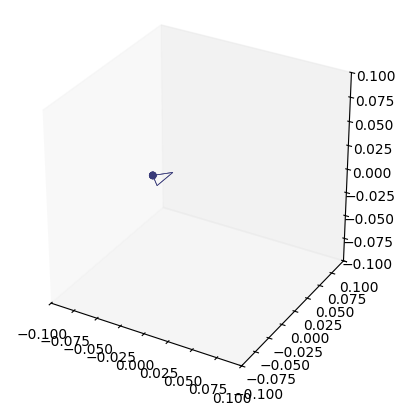

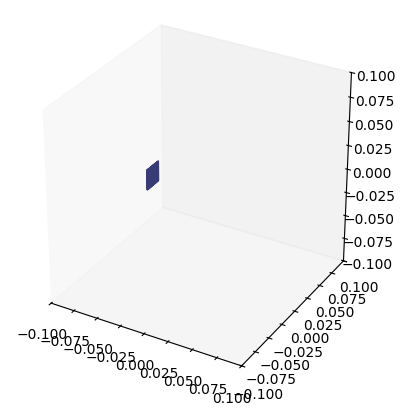

In [5]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
test_transducer_set.assign_pose(0, geometry.Transform([0,0,0], [-0.05,0,0]))

test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [6]:
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [ ]:
simprops = simulation.SimProperties(
                grid_size   = (80e-3,20e-3,20e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                grid_lambda = 2,               # 
                )

In [16]:
test_experiment = experiment.Experiment(
                 simulation_path = 'intro_demo',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 3,
                 additional_keys = []
                 )

test_experiment.save()

In [17]:
test_experiment = experiment.Experiment.load('intro_demo')
test_experiment.run(dry=False, repeat=False) # dry = True will load the data from a previously saved simulation instead of running a new one

Found no more simulations to run.


In [18]:
test_experiment.run(dry=True)

dry run of simulation


100%|██████████| 1/1 [00:00<00:00, 21.71it/s]


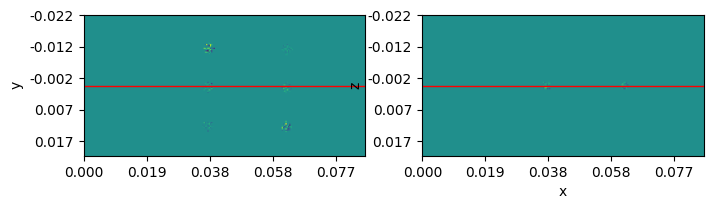

In [19]:
test_experiment.plot_ray_path(32)

In [ ]:
test_experiment.add_results()

In [ ]:
test_reconstruction = reconstruction.DAS(experiment=test_experiment)

In [ ]:
signals = test_reconstruction.get_signals(dimensions=2, matsize=1024, downsample=1, workers=16, tgc=10)

100%|██████████| 64/64 [00:02<00:00, 22.80it/s]
1it [00:01,  1.30s/it]


[]

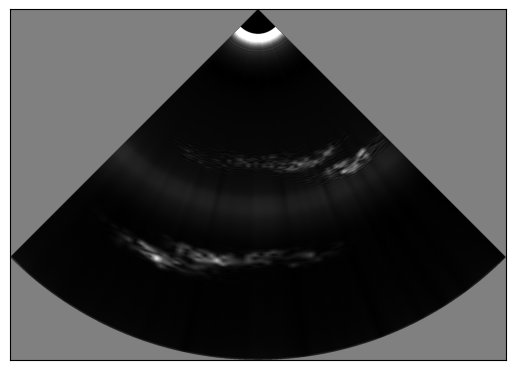

In [ ]:
plt.imshow(signals[0], vmax=20000, cmap='gray')
plt.gca().set_facecolor('gray')
plt.gca().set_xticks([])
plt.gca().set_yticks([])